<a href="https://colab.research.google.com/github/dtuleva/DL_23_Lectures_and_Quests/blob/main/RRS_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
!pip install -q tensorflow-recommenders

In [100]:
!pip install -q mlflow

In [101]:
!pip install -U -q tensorboard_plugin_profile

In [102]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [103]:
from typing import Dict, Text


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_recommenders as tfrs

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import IntegerLookup, Embedding, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

import mlflow

# Recipe Recommendation System
## part 3 - Experiments

## Data pipeline

In [104]:
# ratings_data = pd.read_csv("/content/gdrive/MyDrive/RRS_data/core-data-train_rating.csv")
# ratings_data_val = pd.read_csv("/content/gdrive/MyDrive/RRS_data/core-data-valid_rating.csv")
# recipes_data = pd.read_csv("/content/gdrive/MyDrive/RRS_data/core-data_recipe.csv")

In [105]:
ratings_data = pd.read_csv("/content/mock-data_interaction_10.csv")

In [106]:
# TODO: move to pipeline
ratings_data.dateLastModified = pd.to_datetime(ratings_data.dateLastModified).astype(int)

In [107]:
recipes_unique = ratings_data.recipe_id.unique()

In [108]:
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_data))
# ratings_val = tf.data.Dataset.from_tensor_slices(dict(ratings_data_val))
recipes = tf.data.Dataset.from_tensor_slices(recipes_unique)

In [109]:
# tf.data.experimental.make_csv_dataset(
#     file_pattern,
#     batch_size,
#     column_names=None,
#     column_defaults=None,
#     label_name=None,
#     select_columns=None,
#     field_delim=',',
#     use_quote_delim=True,
#     na_value='',
#     header=True,
#     num_epochs=None, # remember to put num epochs in fit!
#     shuffle=True,
#     shuffle_buffer_size=10000,
#     shuffle_seed=None,
#     prefetch_buffer_size=None,
#     num_parallel_reads=None,
#     sloppy=False,
#     num_rows_for_inference=100,
#     compression_type=None,
#     ignore_errors=False,
#     encoding='utf-8'
# )

In [110]:
# def load_image(recipe_id, dir_path = "/content/"):

#   image_path = dir_path + tf.strings.as_string(recipe_id) + ".jpg"
#   img = tf.io.read_file(image_path)
#   img = tf.io.decode_jpeg(img)

#   return img

In [111]:
def preprocess_image(img, image_size = (224, 224)):

    img = tf.image.resize(img, image_size)
    img = preprocess_input(img) # tensorflow.keras.applications.resnet50.preprocess_input
    # The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

    return img


In [112]:
def decode_and_preprocess_image(img):
    img = tf.io.decode_jpeg(img)
    img = preprocess_image(img)

    return img


In [113]:
def parse_proto_example(proto):
    feature_description = {
      "recipe_id": tf.io.FixedLenFeature([], tf.int64),
      "recipe_name": tf.io.FixedLenFeature([], tf.string),
      "recipe_image": tf.io.FixedLenFeature([], tf.string),
      "aver_rate": tf.io.FixedLenFeature([], tf.float32),
      "review_nums": tf.io.FixedLenFeature([], tf.int64),
      "ingredients": tf.io.FixedLenFeature([], tf.string),
      "cooking_directions": tf.io.FixedLenFeature([], tf.string),
      "reviews": tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(proto, feature_description)

In [114]:
def read_and_parse_proto_file(recipe_id, dir_path = "/content/"):

    file_path = dir_path + tf.strings.as_string(recipe_id) + ".proto"
    proto = tf.io.read_file(file_path)

    return parse_proto_example(proto)


In [115]:
# def load_and_parse_proto(recipe_id, ):
#     file_path = dir_path + tf.strings.as_string(recipe_id) + ".proto"
#     recipe_info = parse_proto_example(file_path)

#     return recipe_info

In [165]:
ratings = ratings.map(lambda x: {
    "recipe_id": x["recipe_id"],
    "user_id": x["user_id"],
    "dateLastModified": x["dateLastModified"],
    "recipe_info": read_and_parse_proto_file(x["recipe_id"]),
    })


In [166]:
# recipe_info = ratings.map(lambda x: {
#     "recipe_info": read_and_parse_proto_file(x["recipe_id"]),
# })

In [117]:
recipes = recipes.map(lambda x: {
    "recipe_id": x,
    "recipe_info": read_and_parse_proto_file(x),
    })

In [118]:
for el in ratings.take(1):
  [print(f"{k}: {v}") for k, v in el.items()]
  [print(f"{k}: {v}") for k, v in el["recipe_info"].items()]



recipe_id: 222388
user_id: 8542392
dateLastModified: 1492865203663000000
recipe_info: {'aver_rate': <tf.Tensor: shape=(), dtype=float32, numpy=5.0>, 'cooking_directions': <tf.Tensor: shape=(), dtype=string, numpy=b'pork belly^smoked paprika^kosher salt^ground black pepper'>, 'ingredients': <tf.Tensor: shape=(), dtype=string, numpy=b'pork belly^smoked paprika^kosher salt^ground black pepper'>, 'recipe_id': <tf.Tensor: shape=(), dtype=int64, numpy=222388>, 'recipe_image': <tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x00\x04\x02\x03\x03\x03\x02\x04\x03\x03\x03\x04\x04\x04\x04\x05\t\x06\x05\x05\x05\x05\x0b\x08\x08\x06\t\r\x0b\r\r\r\x0b\x0c\x0c\x0e\x10\x14\x11\x0e\x0f\x13\x0f\x0c\x0c\x12\x18\x12\x13\x15\x16\x17\x17\x17\x0e\x11\x19\x1b\x19\x16\x1a\x14\x16\x17\x16\xff\xdb\x00C\x01\x04\x04\x04\x05\x05\x05\n\x06\x06\n\x16\x0f\x0c\x0f\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\

In [119]:
for el in recipes.take(1):
  print(el)

{'recipe_id': <tf.Tensor: shape=(), dtype=int64, numpy=222388>, 'recipe_info': {'aver_rate': <tf.Tensor: shape=(), dtype=float32, numpy=5.0>, 'cooking_directions': <tf.Tensor: shape=(), dtype=string, numpy=b'pork belly^smoked paprika^kosher salt^ground black pepper'>, 'ingredients': <tf.Tensor: shape=(), dtype=string, numpy=b'pork belly^smoked paprika^kosher salt^ground black pepper'>, 'recipe_id': <tf.Tensor: shape=(), dtype=int64, numpy=222388>, 'recipe_image': <tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x00\x04\x02\x03\x03\x03\x02\x04\x03\x03\x03\x04\x04\x04\x04\x05\t\x06\x05\x05\x05\x05\x0b\x08\x08\x06\t\r\x0b\r\r\r\x0b\x0c\x0c\x0e\x10\x14\x11\x0e\x0f\x13\x0f\x0c\x0c\x12\x18\x12\x13\x15\x16\x17\x17\x17\x0e\x11\x19\x1b\x19\x16\x1a\x14\x16\x17\x16\xff\xdb\x00C\x01\x04\x04\x04\x05\x05\x05\n\x06\x06\n\x16\x0f\x0c\x0f\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16

recipe_id: 222388
recipe_info: {'aver_rate': <tf.Tensor: shape=(), dtype=float32, numpy=5.0>, 'cooking_directions': <tf.Tensor: shape=(), dtype=string, numpy=b'pork belly^smoked paprika^kosher salt^ground black pepper'>, 'ingredients': <tf.Tensor: shape=(), dtype=string, numpy=b'pork belly^smoked paprika^kosher salt^ground black pepper'>, 'recipe_id': <tf.Tensor: shape=(), dtype=int64, numpy=222388>, 'recipe_image': <tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x00\x04\x02\x03\x03\x03\x02\x04\x03\x03\x03\x04\x04\x04\x04\x05\t\x06\x05\x05\x05\x05\x0b\x08\x08\x06\t\r\x0b\r\r\r\x0b\x0c\x0c\x0e\x10\x14\x11\x0e\x0f\x13\x0f\x0c\x0c\x12\x18\x12\x13\x15\x16\x17\x17\x17\x0e\x11\x19\x1b\x19\x16\x1a\x14\x16\x17\x16\xff\xdb\x00C\x01\x04\x04\x04\x05\x05\x05\n\x06\x06\n\x16\x0f\x0c\x0f\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16\x16

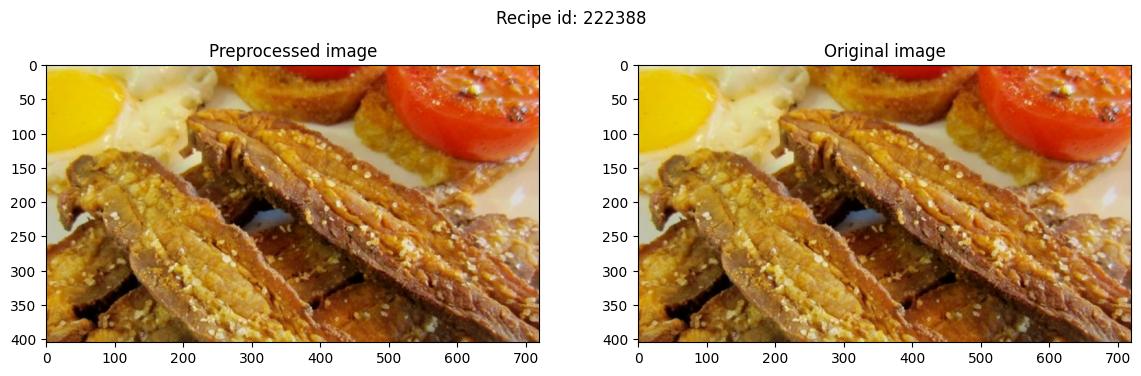

In [123]:
for el in recipes.take(1):
  [print(f"{k}: {v}") for k, v in el.items()]

  recipe_id = el["recipe_id"]
  image = el["recipe_info"]["recipe_image"]

  fig, axs = plt.subplots(1,2, figsize=(14, 4))
  plt.suptitle(f'Recipe id: {recipe_id}')

  axs[0].set_title("Preprocessed image")
  axs[0].imshow(tf.io.decode_jpeg(image))
  axs[1].set_title("Original image")
  axs[1].imshow(tf.io.decode_jpeg(image))


In [ ]:
# ratings = ratings.map(lambda x: {
#     "recipe_id": x["recipe_id"],
#     "user_id": x["user_id"]
# })

# ratings_val = ratings_val.map(lambda x: {
#     "recipe_id": x["recipe_id"],
#     "user_id": x["user_id"]
# })

# recipes = recipes.map(lambda x: x["recipe_id"])

In [ ]:
# for r in recipes.take(1):
#   print(r)

In [124]:
ratings.cardinality(), recipes.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=417>,
 <tf.Tensor: shape=(), dtype=int64, numpy=10>)

In [125]:
unique_user_ids = ratings_data.user_id.unique()
len(unique_user_ids)

415

In [126]:
unique_recipe_ids = ratings_data.recipe_id.unique() # here
len(unique_recipe_ids)

10

In [127]:
# movie_title_lookup.adapt(ratings.map(lambda x: x["movie_title"]))

In [128]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["dateLastModified"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)


In [129]:
# AUTOTUNE = tf.data.AUTOTUNE

# # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# dog_muffin_list_train_perf_config = dog_muffin_list_train.map(process_path, num_parallel_calls=AUTOTUNE)
# dog_muffin_list_val_perf_config = dog_muffin_list_val.map(process_path, num_parallel_calls=AUTOTUNE)

In [130]:
# def configure_for_performance(ds):
#   ds = ds.cache()
#   ds = ds.shuffle(buffer_size=ds.cardinality())
#   ds = ds.batch(batch_size)
#   ds = ds.prefetch(buffer_size=AUTOTUNE)
#   return ds

# dog_muffin_list_train_perf_config = configure_for_performance(dog_muffin_list_train_perf_config)
# dog_muffin_list_val_perf_config = configure_for_performance(dog_muffin_list_val_perf_config)

In [131]:
ratings_train = ratings.take(300).batch(20)
ratings_val = ratings.skip(300).take(117).batch(20)

## Model definition

In [132]:
embedding_dimension = 32

### Query model

In [133]:
# # query tower

# user_model = Sequential([
#   IntegerLookup(
#       vocabulary=unique_user_ids, mask_token=None),
#   # We add an additional embedding to account for unknown tokens.
#   tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
# ])

In [134]:
class UserModel(tf.keras.Model):

  def __init__(self, use_timestamps):
    super().__init__()

    self._use_timestamps = use_timestamps

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.IntegerLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

    if use_timestamps:
      self.timestamp_embedding = tf.keras.Sequential([
          tf.keras.layers.Discretization(timestamp_buckets.tolist()),
          tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
      ])
      self.normalized_timestamp = tf.keras.layers.Normalization(
          axis=None
      )

      self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    if not self._use_timestamps:
      return self.user_embedding(inputs["user_id"])

    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["dateLastModified"]),
        tf.reshape(self.normalized_timestamp(inputs["dateLastModified"]), (-1, 1)),
    ], axis=1)

### Candidate model

#### Recipe ID

In [135]:
# id hash / integer lookup

#### Recipe Image

In [136]:
resnet50 = ResNet50()

In [137]:
# resnet50.summary()

In [142]:
sample_images = recipes.take(5).map(lambda x: tf.io.decode_jpeg(x["recipe_info"]["recipe_image"]))
sample_images

<_MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>

In [143]:
decode_predictions(resnet50.predict(sample_images.batch(10)), top = 3)

1/1 [==============================] - 6s 6s/step


[[('n01986214', 'hermit_crab', 0.04626629),
  ('n02066245', 'grey_whale', 0.02465823),
  ('n01496331', 'electric_ray', 0.024219977)],
 [('n02066245', 'grey_whale', 0.18550168),
  ('n01484850', 'great_white_shark', 0.08206556),
  ('n09229709', 'bubble', 0.074003965)],
 [('n02939185', 'caldron', 0.023071459),
  ('n07880968', 'burrito', 0.02183181),
  ('n04209133', 'shower_cap', 0.020127872)],
 [('n01945685', 'slug', 0.06391163),
  ('n02165456', 'ladybug', 0.052404433),
  ('n01986214', 'hermit_crab', 0.051694397)],
 [('n01930112', 'nematode', 0.20826827),
  ('n09229709', 'bubble', 0.13111511),
  ('n02134084', 'ice_bear', 0.044182826)]]

In [145]:
sample_images = recipes.take(5).map(lambda x: decode_and_preprocess_image(x["recipe_info"]["recipe_image"]))

In [146]:
decode_predictions(resnet50.predict(sample_images.batch(10)), top = 3)

1/1 [==============================] - 2s 2s/step


[[('n02776631', 'bakery', 0.39453843),
  ('n07871810', 'meat_loaf', 0.16423157),
  ('n07697537', 'hotdog', 0.09502021)],
 [('n07711569', 'mashed_potato', 0.55543333),
  ('n07871810', 'meat_loaf', 0.12479975),
  ('n07684084', 'French_loaf', 0.08913466)],
 [('n07579787', 'plate', 0.35388964),
  ('n07831146', 'carbonara', 0.24616367),
  ('n07711569', 'mashed_potato', 0.15107054)],
 [('n07684084', 'French_loaf', 0.7221588),
  ('n02776631', 'bakery', 0.041738123),
  ('n07717410', 'acorn_squash', 0.03962634)],
 [('n07831146', 'carbonara', 0.30425817),
  ('n07860988', 'dough', 0.13138953),
  ('n04597913', 'wooden_spoon', 0.12432582)]]

In [147]:
resnet50_backbone = ResNet50(include_top = False, input_shape = (224, 224, 3))

In [148]:
resnet50_backbone.layers[-1].output_shape

(None, 7, 7, 2048)

In [149]:
resnet50_backbone.trainable = False

In [150]:
image_embedding = tf.keras.Sequential(
    layers = [
      resnet50_backbone,
      GlobalAveragePooling2D(),
      Dense(32)
      ],
    name = "image_embedding"
)

In [151]:
image_embedding.summary()

Model: "image_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 32)                65568     
                                                                 
Total params: 23653280 (90.23 MB)
Trainable params: 65568 (256.12 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [152]:
for img in sample_images.batch(10):
  image_embedding(img)

In [153]:
id_embedding = tf.keras.Sequential([
      tf.keras.layers.IntegerLookup(
          vocabulary=unique_recipe_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_recipe_ids) + 1, 32)
    ])

In [154]:
# id_embedding.layers[-1].output_shape

In [155]:
# candidate tower

# recipe_model = Sequential([
#   IntegerLookup(
#       vocabulary=unique_recipe_ids, mask_token=None),
#   tf.keras.layers.Embedding(len(unique_recipe_ids) + 1, embedding_dimension)
# ])

In [157]:
class RecipeModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.id_embedding = tf.keras.Sequential([
      tf.keras.layers.IntegerLookup(
          vocabulary=unique_recipe_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_recipe_ids) + 1, 32)
    ])


    self.image_embedding = tf.keras.Sequential(name = "image_embedding", layers = [
        ResNet50(include_top = False),
        GlobalAveragePooling2D(),
        Dense(32)
    ])

    # self.title_vectorizer = tf.keras.layers.TextVectorization(
    #     max_tokens=max_tokens)

    # self.title_text_embedding = tf.keras.Sequential([
    #   self.title_vectorizer,
    #   tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
    #   tf.keras.layers.GlobalAveragePooling1D(),
    # ])

    # self.title_vectorizer.adapt(unique_recipe_names)

  def call(self, inputs):
    return tf.concat([
        self.id_embedding(inputs["recipe_id"]),
        # self.title_text_embedding(inputs["recipe_name"]),
        self.image_embedding(inputs["recipe_info"]["recipe_image"]),
    ], axis=1)

In [162]:
class RecipeRecommedModel(tfrs.models.Model):

  def __init__(self, use_timestamps):
    super().__init__()
    self.query_model = tf.keras.Sequential(name = "query_model", layers = [
      UserModel(use_timestamps),
      tf.keras.layers.Dense(32)
    ])
    self.candidate_model = tf.keras.Sequential(name = "candidate_model", layers = [
      RecipeModel(),
      tf.keras.layers.Dense(32)
    ])
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=recipes.batch(10).map(self.candidate_model), # here
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "dateLastModified": features["dateLastModified"],
    })
    recipe_embeddings = self.candidate_model({
        "recipe_id": features["recipe_id"],
        # "recipe_name": features["recipe_name"],
        "recipe_image": features["recipe_info"]["recipe_image"],
    })

    return self.task(query_embeddings, recipe_embeddings)

In [163]:
tf.keras.backend.clear_session()

In [164]:
model = RecipeRecommedModel(use_timestamps=False)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))


ValueError: Exception encountered when calling layer 'recipe_model' (type RecipeModel).

in user code:

    File "<ipython-input-157-a84e0b753da8>", line 36, in call  *
        self.image_embedding(inputs["recipe_info"]["recipe_image"]),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'resnet50' (type Functional).
    
    Input 0 of layer "conv1_pad" is incompatible with the layer: expected ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'resnet50' (type Functional):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=None
      • mask=None


Call arguments received by layer 'recipe_model' (type RecipeModel):
  • inputs={'recipe_id': 'tf.Tensor(shape=(None,), dtype=int64)', 'recipe_info': {'aver_rate': 'tf.Tensor(shape=(None,), dtype=float32)', 'cooking_directions': 'tf.Tensor(shape=(None,), dtype=string)', 'ingredients': 'tf.Tensor(shape=(None,), dtype=string)', 'recipe_id': 'tf.Tensor(shape=(None,), dtype=int64)', 'recipe_image': 'tf.Tensor(shape=(None,), dtype=string)', 'recipe_name': 'tf.Tensor(shape=(None,), dtype=string)', 'review_nums': 'tf.Tensor(shape=(None,), dtype=int64)', 'reviews': 'tf.Tensor(shape=(None,), dtype=string)'}}

In [ ]:
model.candidate_model.layers[0].image_embedding.layers[0].trainable = False #  freezing resnet50 backbone

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = "/log_3/", # no "content" in dir path!!!
                                                 histogram_freq = 1, # frequency (in epochs) at which to compute weight histograms for the layers of the model
                                                 profile_batch = '2, 5' #  A pair of positive integers signify a range of batches to profile
                                                 )

In [ ]:
# Load the TensorBoard notebook extension.
#%load_ext tensorboard

%reload_ext tensorboard

In [ ]:
%tensorboard --logdir="/log_3"


In [ ]:
# experiment = mlflow.create_experiment("retrieval_sample_10")

In [ ]:
# experiment

# 378239632256356911

In [ ]:
mlflow.autolog()
# mlflow.autolog(disable = True)

In [ ]:
# with mlflow.start_run(experiment_id = experiment, run_name="autolog_02") as run:
model.fit(
    ratings_train,
    validation_data = ratings_val,
    epochs = 2,
    initial_epoch = 1,
    callbacks = [tensorboard_callback],
    )

In [ ]:
# zip tensorboard logs
!zip -r /content/log.zip /content/log/

In [ ]:
# zip mlflow logs
!zip -r /content/mlruns.zip /content/mlruns